# Growth and seasonal component analysis in time series

We look at the Mauna Loa observatory measurments of atmospheric $CO_2$, more specifically, the monthly dataset from 1958 to 2019, trying to understand the long-term growth and the monthly seasonality. The dataset can be downloaded [here](http://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo).

In [1]:
from datetime import timedelta
import calendar

import numpy as np
import pandas as pd
import scipy as sp
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import arviz as az

pd.plotting.register_matplotlib_converters()
plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format='retina'

### Loading the data

In [2]:
data = pd.read_csv('monthly_in_situ_co2_mlo.csv', header=56)

# missing data is marked as -99.99
data = data.replace(to_replace=-99.99, value=np.nan)
data = data.dropna().reset_index(drop=True)

data.columns = ["year", "month", "_1", "_2", "CO2", "_3", "_4", "_5", "_6", "_7"]
data = data[['year', 'month', 'CO2']]

data = data.assign(date = data.apply(
    lambda row: pd.Timestamp(year=int(row.year), month=int(row.month), day=1), 
    axis=1))

data = data.assign(month_i = data.date.dt.year * 12 + data.date.dt.month)
data = data.assign(month_i = data.month_i - data.month_i.min())
data = data.sort_values('date').reset_index(drop=True)

data.head(5)

,year,month,CO2,date,month_i
0,1958,3,315.70,1958-03-01,0
1,1958,4,317.45,1958-04-01,1
2,1958,5,317.51,1958-05-01,2
3,1958,7,315.86,1958-07-01,4
4,1958,8,314.93,1958-08-01,5


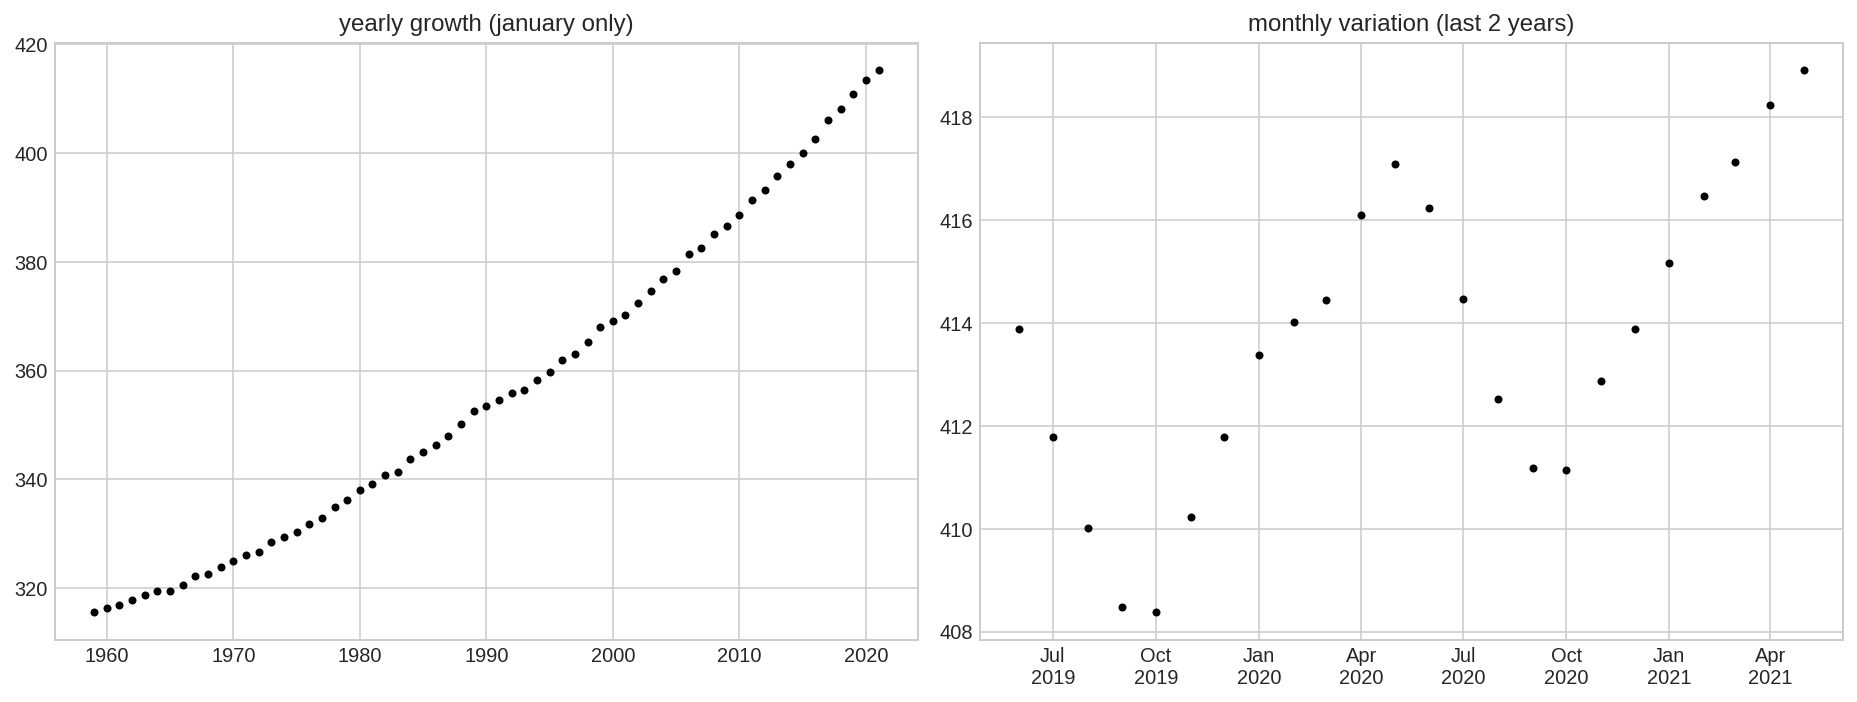

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
ax1.scatter(data[data.month == 1].year, data[data.month == 1].CO2, marker='.', c='k')
ax1.set(title='yearly growth (january only)')
ax2.scatter(data.date[-24:], data.CO2[-24:], marker='.', c='k')
ax2.set(title='monthly variation (last 2 years)')
ax2.xaxis.set_major_formatter(DateFormatter('%b\n%Y'))
fig.tight_layout()
None

## Model

We start with choosing the normal distribution as the likelihood of observing a certain value for the  $\text{CO}_2$ measurement:

$$ \text{CO}_2 \sim \mathcal{N}(\mu, \sigma) $$

We will use a two-component model:

$$ \mu_t = g(t) + p(m) $$

where $t$ is the number of months since the first one (March 1958), and $m$ is the month in the year, from 0 to 11.

The trend $g$ can be modeled as non-centered parametrization of Gaussian random walk: 

$$ g(t) = 310 + \frac{1}{7} t + M_t $$

where $M_t$ is a mid-range variation:

$$ M_t \sim \mathcal{N}(M_{t-1}, 0.05^2) $$

The periodical component $p$ can be modeled with an inverse Fourier transorm with period of 12 and order of 3:

$$ p(m) = \sum_{k=1}^{3}\big( {S_k \sin{\frac{2 \pi k m}{12}} + C_k \cos{\frac{2 \pi k m}{12}  } }\big) $$

What remains is choosing priors for the free parameters in the model:

$$ \sigma \sim \text{Half-Cauchy}(0.5) $$

$$ S_k, C_k \sim \mathcal{N}(0, 2^2), k = 1, 2, 3 $$

In [4]:
# fourier transform order
ft_order = 3

t_max = data.month_i.max()

rho = 0.05


with pm.Model() as m1:

    # mid-range variation on linear trend
    M = pm.GaussianRandomWalk('M', sigma=rho, init=pm.Normal.dist(0, 1), shape=t_max+1)

    g = pm.Deterministic('g', 315 + 1/7 * np.arange(0, t_max + 1) + M)

    # inverse fourier
    sk = pm.Normal('sk', mu=0, sd=2, shape=ft_order)
    ck = pm.Normal('ck', mu=0, sd=2, shape=ft_order)

    # seasonal
    comps = []
    p = 0
    for k in range(1, ft_order+1):
        phi = 2 * np.pi * k * np.arange(0, 12) / 12
        sin_comp = sk[k-1] * np.sin(phi)
        cos_comp = ck[k-1] * np.cos(phi)
        comps.append([sin_comp, cos_comp])
        p = p + sin_comp + cos_comp

    p = pm.Deterministic('p', p)

    # the individual components
    comps = pm.Deterministic('components', pm.math.stack(comps))

    # putting it together
    g_i = g[data.month_i.values]
    p_i = p[data.month.values - 1]
    mu = pm.Deterministic('mu', g_i + p_i)

    # inference
    sigma = pm.HalfCauchy('sigma', 0.5)
    pm.Normal('co2', mu, sigma, observed=data.CO2.values)

    m1.trace = pm.sample(6000, tune=6000, chains=2)

/tmp/ipykernel_464505/3602728687.py:44: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  m1.trace = pm.sample(6000, tune=6000, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, ck, sk, M]


Sampling 2 chains for 6_000 tune and 6_000 draw iterations (12_000 + 12_000 draws total) took 266 seconds.


/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


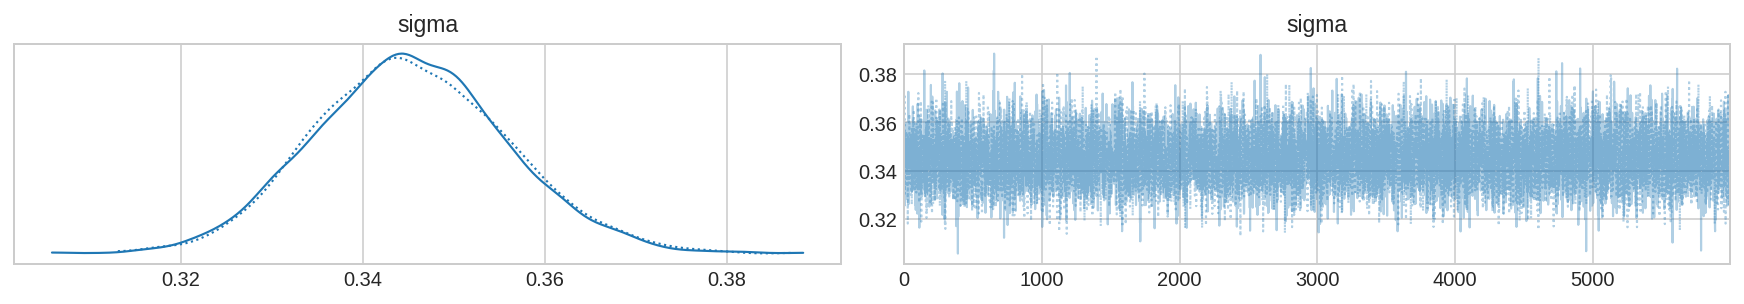

In [5]:
az.plot_trace(m1.trace, var_names=['sigma'])
None

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


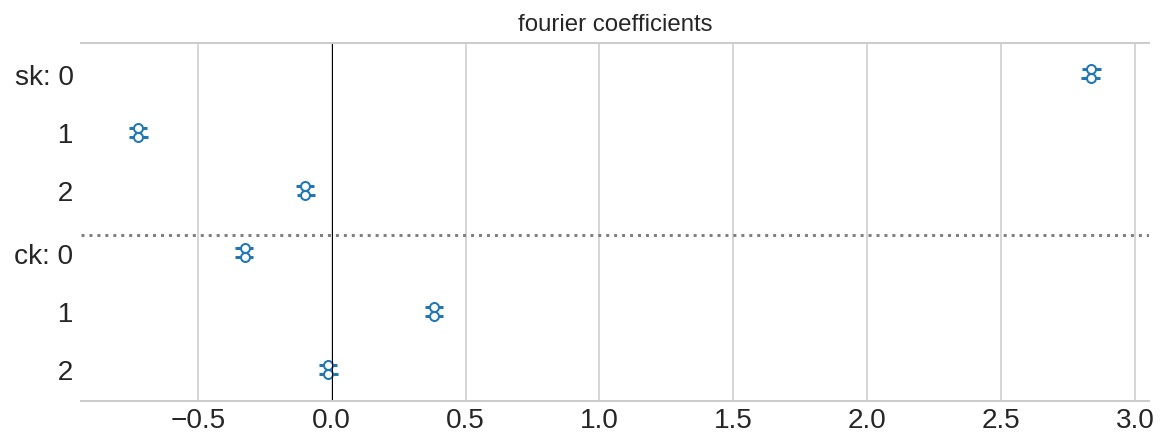

In [6]:
az.plot_forest(m1.trace, var_names=['sk', 'ck'], figsize=(8, 3))
plt.axhline(7, color='gray', linestyle=':')
plt.axvline(color='k', linewidth=0.5)
plt.gca().set(title='fourier coefficients')
None

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


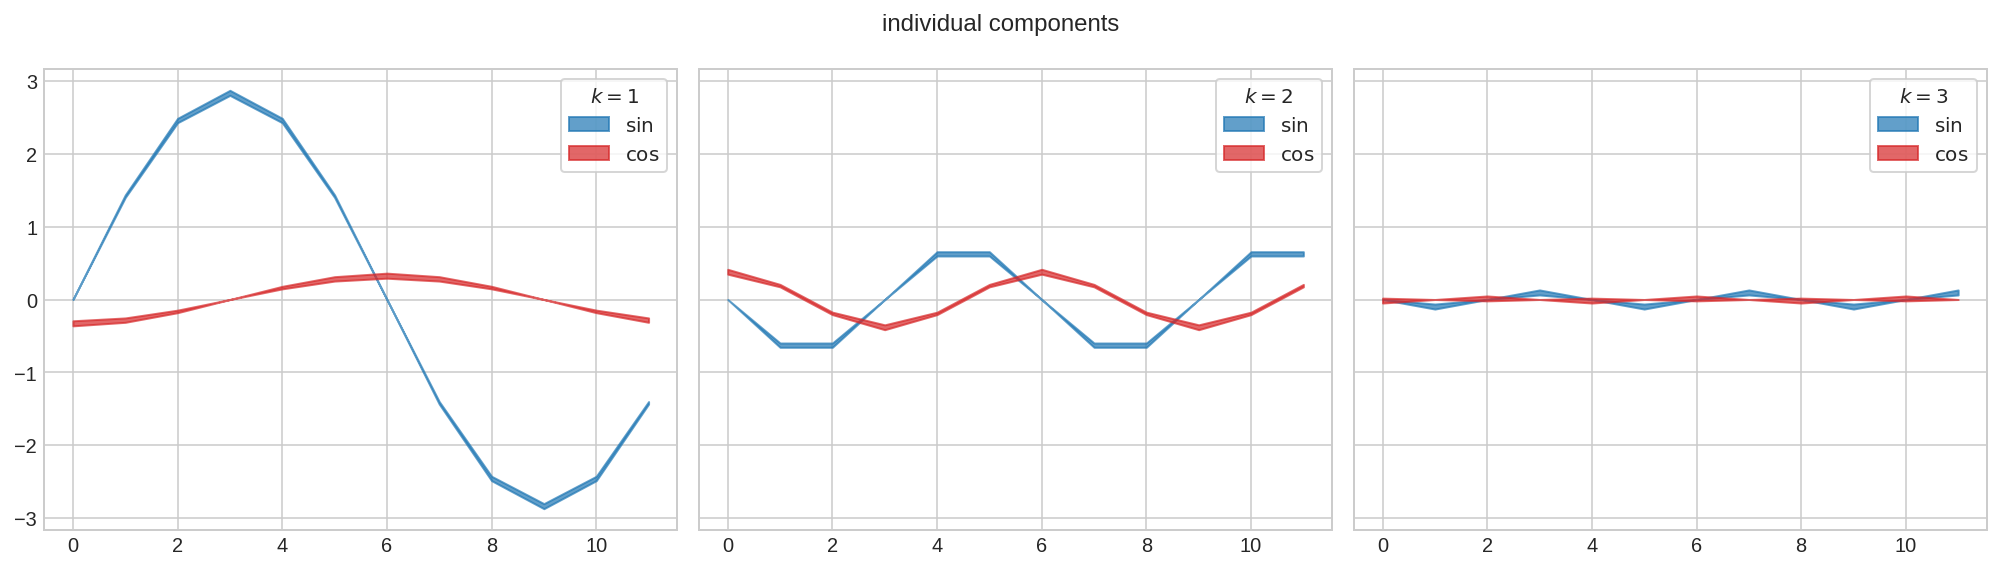

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)
axes = axes.reshape(-1)
for i in range(ft_order):
    tmp = az.hdi(m1.trace['components'][:, i, 0, :])
    axes[i].fill_between(range(12), tmp[:, 0], tmp[:, 1], alpha=.7, color='C0', label=f'$\sin$')
    tmp = az.hdi(m1.trace['components'][:, i, 1, :])
    axes[i].fill_between(range(12), tmp[:, 0], tmp[:, 1], alpha=.7, color='C3', label=f'$\cos$')
    axes[i].legend(title=f'$k = {i+1}$', frameon=True)

fig.suptitle('individual components')
fig.tight_layout()

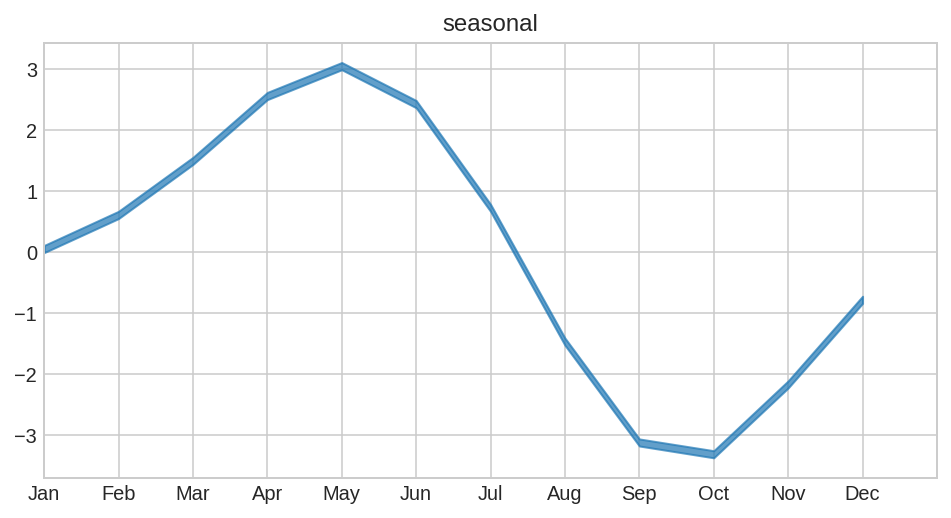

In [8]:
tmp = az.hdi(m1.trace['p'])
plt.figure(figsize=(8, 4))
plt.fill_between(range(12), tmp[:, 0], tmp[:, 1], alpha=.7, color='C0')
plt.gca().set(xlim=(0, 12), title='seasonal',
              xticks=range(0, 12),
              xticklabels=[calendar.month_abbr[i] for i in range(1, 13)])
None

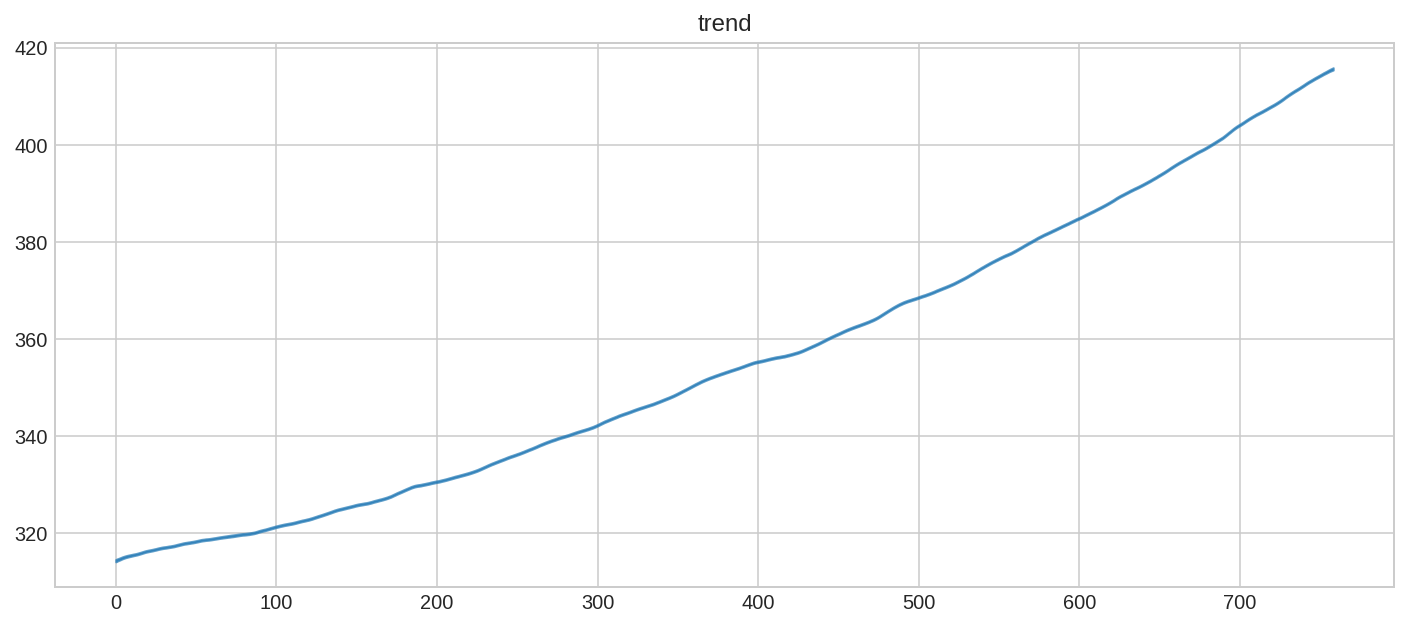

In [9]:
tmp = az.hdi(m1.trace['g'])
plt.figure(figsize=(12, 5))
plt.fill_between(range(data.month_i.max() + 1), tmp[:, 0], tmp[:, 1], alpha=.7, color='C0')
plt.gca().set(title='trend')
None

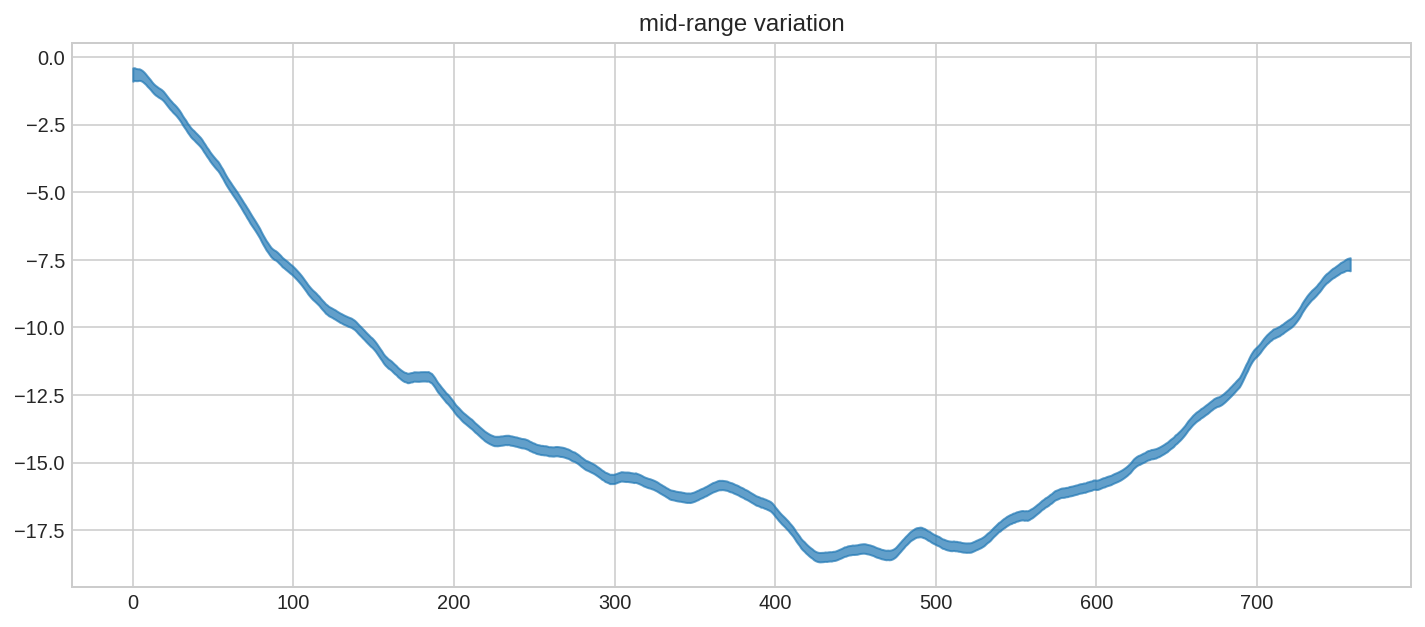

In [10]:
tmp = az.hdi(m1.trace['M'])
plt.figure(figsize=(12, 5))
plt.fill_between(range(data.month_i.max() + 1), tmp[:, 0], tmp[:, 1], alpha=.7, color='C0')
plt.gca().set(title='mid-range variation')
None

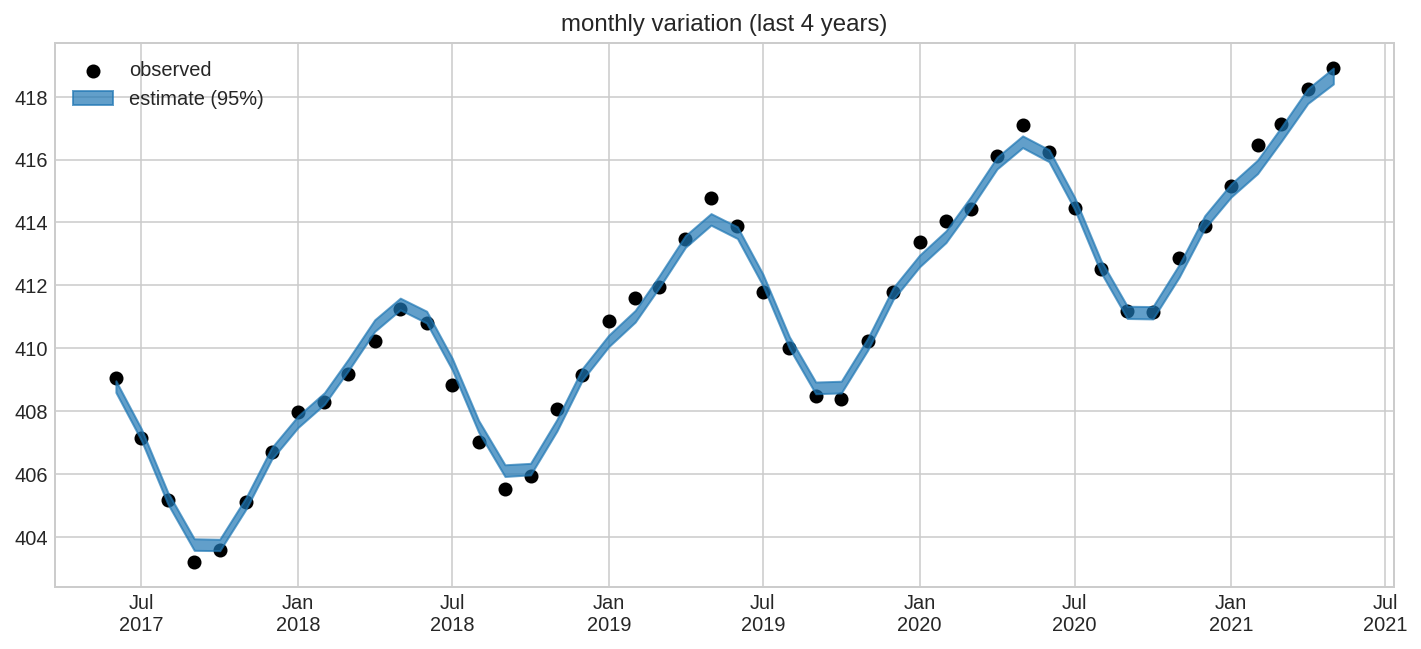

In [12]:
tmp = az.hdi(m1.trace['mu'][:, -48:])
plt.figure(figsize=(12, 5))
plt.scatter(data.date[-48:], data.CO2[-48:],
            label='observed', c='k')
plt.fill_between(data.date[-48:], tmp[:, 0], tmp[:, 1],
                 alpha=.7, color='C0', label='estimate (95%)')
plt.gca().set(title='monthly variation (last 4 years)')
plt.gca().xaxis.set_major_formatter(DateFormatter('%b\n%Y'))
plt.legend()
plt.savefig('monthly_var.svg')
None

---